In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import List
from IPython.display import clear_output

In [3]:
LETTERS = "qабвгдежзийклмнопрстуфхцчшщъыьэюяё"
VOWELS = "аеиоуэюяыё"
N_LETTERS = len(LETTERS)
MAX_WORD_LENGTH = 36

char2ind = {char: i for i, char in enumerate(LETTERS)}
ind2char = {i: char for char, i in char2ind.items()}

In [4]:
train = open('drive/MyDrive/rucode-D data/train_stresses_labels.txt', 'r', encoding="utf8").readlines()
for i in range(len(train)):
    train[i] = train[i][:-1]
train[:5]

['аа^к', 'аа^ка', 'аа^ке', 'аа^ки', 'аа^ков']

In [5]:
test = open('drive/MyDrive/rucode-D data/public_test_stresses.txt', 'r', encoding="utf8").readlines()
for i in range(len(test)):
    test[i] = test[i][:-1]
test[:5]

['аакам', 'ааками', 'ааленец', 'аама', 'аамами']

In [10]:
test_private = open('drive/MyDrive/rucode-D data/private_test_stresses.txt', 'r', encoding="utf8").readlines()
for i in range(len(test_private)):
    test_private[i] = test_private[i][:-1]
test_private[:5]

['ааках', 'ааку', 'аал', 'аамам', 'аамах']

In [6]:
X, y = [], []
for i in tqdm(range(len(train))):
    X.append(train[i].replace('^', ''))
    correct_pos = train[i].find('^')
    y.append(correct_pos)
X[:5], y[:5]

100%|██████████| 588490/588490 [00:00<00:00, 1189603.52it/s]


(['аак', 'аака', 'ааке', 'ааки', 'ааков'], [2, 2, 2, 2, 2])

In [7]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)
X_train, y_train = X, y

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
class CustomDataset:
    def __init__(self, X, y):
        self.data = []
        self.pad_id = char2ind['q']

        assert len(X) == len(y), "X and y must be same length"
        for word, label in zip(X, y):
            self.data.append({
                'word': word,
                'label': label
            })

    def __getitem__(self, idx: int) -> List[int]:
        preprocessed_word = [char2ind[char] for char in self.data[idx]['word']]

        train_sample = {
            "text": preprocessed_word,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=char2ind['q'], max_len=MAX_WORD_LENGTH) -> torch.Tensor:
    words_lengths = [len(x['text']) for x in input_batch]
    # max_word_length = min(max(words_lengths), max_len)
    max_word_length = max_len

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_word_length]
        for _ in range(max_word_length - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    words = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': words,
        'label': labels
    }

    return new_batch

In [11]:
train_files = CustomDataset(X_train, y_train)
# val_files = CustomDataset(X_val, y_val)

batch_size = 128
train_loader = DataLoader(train_files, collate_fn=collate_fn_with_padding, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_files, collate_fn=collate_fn_with_padding, batch_size=batch_size, shuffle=False)

In [12]:
def evaluate(model, val_dataloader) -> float:
    model.eval()

    predictions = []
    target = []
    with torch.no_grad():
        for batch in val_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    model.train()
    return accuracy

In [13]:
def train(model, criterion, optimizer, num_epoch):
    losses = []
    acc = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_loader, desc=f'Training epoch {epoch}')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        # acc.append(evaluate(model, val_loader))
        losses.append(sum(epoch_losses) / len(epoch_losses))

        clear_output(True)
        # print(f"Epoch #{epoch + 1}/{num_epoch} | loss: {losses[-1]} | acc: {acc[-1] * 100:.2f}")
        print(f"Epoch #{epoch + 1}/{num_epoch} | loss: {losses[-1]}")

        # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        # ax1.plot(np.arange(len(losses)), losses)
        # ax1.set_title('Losses')
        # ax1.set_xlabel("epoch")

        # ax2.plot(np.arange(len(acc)), acc)
        # ax2.set_title('Accuracy')
        # ax2.set_xlabel("epoch")

        plt.plot(range(1, len(losses) + 1), losses)
        plt.title('Losses')
        plt.xlabel("epoch")
        plt.show()

    return losses, acc

In [14]:
class RNN(nn.Module):
    def __init__(self, hidden_dim: int, aggregation_type: str = 'weighted'):
        super().__init__()
        self.embedding = nn.Embedding(N_LETTERS, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.1, bidirectional=True)
        self.linear = nn.Linear(2 * hidden_dim, hidden_dim)
        self.projection = nn.Linear(2 * hidden_dim, N_LETTERS)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.15)

        self.aggregation_layer = torch.nn.Conv1d(in_channels=MAX_WORD_LENGTH, out_channels=1, kernel_size=1)
        self.aggregation_layer2 = torch.nn.Conv1d(in_channels=MAX_WORD_LENGTH, out_channels=1, kernel_size=1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        batch_size = output.shape[0]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        elif self.aggregation_type == 'weighted':
            output = self.aggregation_layer(output).view(batch_size, -1)
        else:
            raise ValueError("Invalid aggregation_type")

        embeddings = self.aggregation_layer2(embeddings).view(batch_size, -1)
        output = self.dropout(self.linear(self.non_lin(output)))
        # print(embeddings.shape, output.shape)

        output = torch.cat((output, embeddings), dim=1)
        # print(output.shape)
        # assert 0
        prediction = self.projection(self.non_lin(output))

        return prediction

In [15]:
model = RNN(hidden_dim=150, aggregation_type='weighted').to(device)

params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {params_count}')

assert params_count <= 1e6

Number of trainable parameters: 965358


In [27]:
def make_train_session(epochs, lr, version):
    train_log = train(
        model,
        criterion=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=lr),
        num_epoch=epochs
    )

    # Saving predictions
    X_test = test
    y_test = range(len(X_test))
    X_test_private = test_private
    y_test_private = range(len(X_test_private))

    model.eval()

    test_files = CustomDataset(X_test, y_test)
    test_private_files = CustomDataset(X_test_private, y_test_private)
    test_loader = DataLoader(test_files, collate_fn=collate_fn_with_padding, batch_size=128, shuffle=False)
    test_private_loader = DataLoader(test_private_files, collate_fn=collate_fn_with_padding, batch_size=128, shuffle=False)

    res = [0] * len(y_test)
    res_private = [0] * len(y_test_private)

    for batch in test_loader:
        with torch.no_grad():
            logits = model(batch['input_ids'])
            preds = torch.argmax(logits, 1)

            for prediction, pos in zip(preds, batch['label']):
                res[pos] = prediction.item()

    for batch in test_private_loader:
        with torch.no_grad():
            logits = model(batch['input_ids'])
            preds = torch.argmax(logits, 1)

            for prediction, pos in zip(preds, batch['label']):
                res_private[pos] = prediction.item()

    with open(f'train_log/predictions_{version}.txt', 'w', encoding="utf8") as f:
        for i, x in enumerate(res):
            f.write(f"{test[i][:x]}^{test[i][x:]}\n")
    with open(f'train_log/predictions_private_{version}.txt', 'w', encoding="utf8") as f:
        for i, x in enumerate(res_private):
            f.write(f"{test_private[i][:x]}^{test_private[i][x:]}\n")

    # Saving model weights
    torch.save(model, f'train_log/model_{version}')

    version += 1

In [21]:
make_train_session(epochs=20, lr=1e-3, version=1)

Epoch #10/10 | loss: 0.006775491098201939


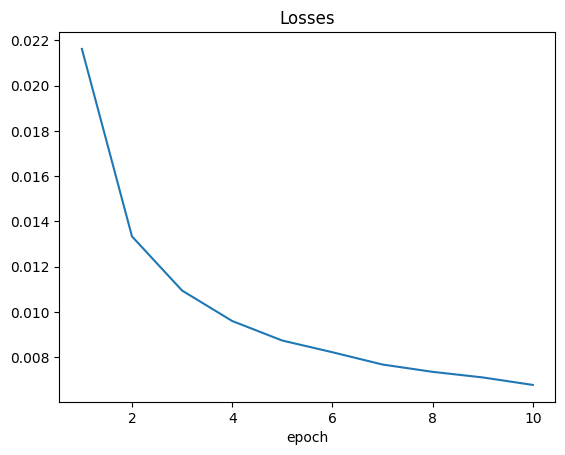

UnboundLocalError: ignored

In [23]:
make_train_session(epochs=10, lr=3e-4, version=2)

Epoch #5/5 | loss: 0.0025844031831922703


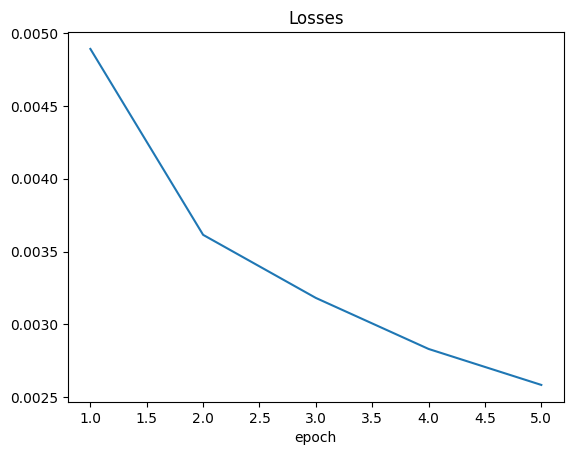

In [28]:
make_train_session(epochs=5, lr=1e-4, version=3)

Epoch #5/5 | loss: 0.0016021985106272792


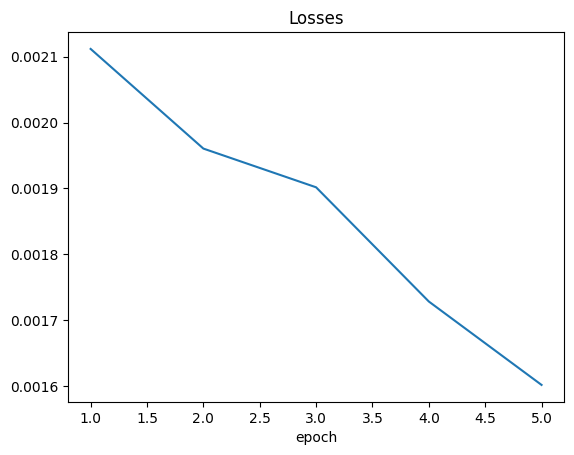

In [29]:
make_train_session(epochs=5, lr=3e-5, version=4)

Epoch #5/5 | loss: 0.0013718399540471864


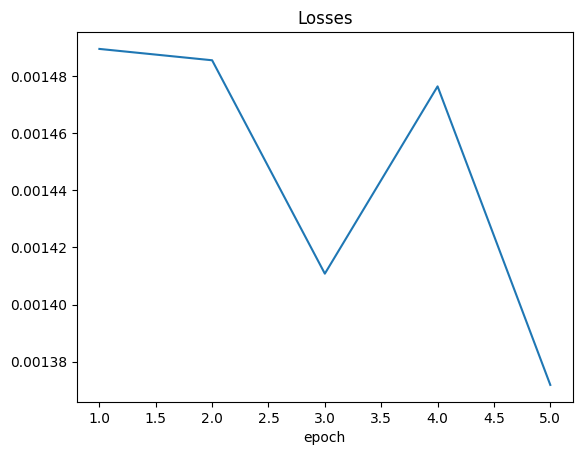

In [30]:
make_train_session(epochs=5, lr=1e-5, version=5)